In [1]:
try:
    import google.colab
    import torch
    COLAB = True
    print("Note: using Google CoLab")
    
    has_mps = torch.backends.mps.is_built()
    device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
except:
    import torch
    print("Note: not using Google CoLab")
    COLAB = False
    
    has_mps = torch.backends.mps.is_built()
    device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cpu


Import data

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

df = pd.read_csv("data.csv",sep=',', header=0,index_col=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df.fillna(method='ffill', inplace=True)  # Forward fill NaNs


num_setups = 3
split_time = 0.5
train_data = df[df['time'] < split_time]  
test_data = df[df['time'] >= split_time]  

print(df.head())
print('train shape: ', train_data.shape)
print('test shape:  ', test_data.shape)

       time         u         x   ID
0  0.000000  0.000000  1.000000  1.0
1  0.001001  0.250125  0.126064  1.0
2  0.002002  0.250251  0.127127  1.0
3  0.003003  0.250376  0.128191  1.0
4  0.004004  0.250502  0.129255  1.0
train shape:  (1500, 4)
test shape:   (1500, 4)


In [3]:
# Select position and control columns
train_array = train_data[['x', 'u']]
test_array = test_data[['x', 'u']]

print(train_array)
#Scale
scaler = StandardScaler()
x_scaler = StandardScaler()
train_array = scaler.fit_transform(train_array)
test_array = scaler.transform(test_array)

print(train_array)
# Reshape test and train arrays
train_array = train_array.reshape(num_setups, train_array.shape[0]//num_setups, 2) 
test_array = test_array.reshape(num_setups, test_array.shape[0]//num_setups, 2)

print('train shape: ', train_array.shape)
print('test shape:  ', test_array.shape)

             x         u
0     1.000000  0.000000
1     0.126064  0.250125
2     0.127127  0.250251
3     0.128191  0.250376
4     0.129255  0.250502
...        ...       ...
2495  0.657698  0.990991
2496  0.659684  0.992993
2497  0.661674  0.994995
2498  0.663668  0.996997
2499  0.665666  0.998999

[1500 rows x 2 columns]
[[ 0.15889072 -0.14625538]
 [ 0.13223399 -0.13861005]
 [ 0.13226644 -0.13860622]
 ...
 [ 0.14857114 -0.11584236]
 [ 0.14863196 -0.11578116]
 [ 0.1486929  -0.11571997]]
train shape:  (3, 500, 2)
test shape:   (3, 500, 2)


In [4]:
# def create_sequences(data, sequence_length):
#     inputs = []
#     targets = []

#     for setup in data:
#         inputs.append(setup[:sequence_length])
#         targets.append(setup[1:sequence_length+1]) # predict only u values

#     return np.array(inputs), np.array(targets)
def create_sequences(data, sequence_length):
    inputs, targets = [], []
    for setup in [1]:#range(data.shape[0]):
        for i in range(data.shape[1] - sequence_length):
            inputs.append(data[setup, i:i+sequence_length, :])
            targets.append(data[setup, i+sequence_length, :])
    return np.array(inputs), np.array(targets)

# Create sequences
x_train, y_train = create_sequences(train_array,5)
x_test, y_test = create_sequences(test_array, 5)

print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)

x train shape:  (495, 5, 2)
y train shape:  (495, 2)
x test shape:  (495, 5, 2)
y test shape:  (495, 2)


In [5]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print('x train shape: ', x_train_tensor.shape)
print('y train shape: ', y_train_tensor.shape)
print('x test shape: ', x_test_tensor.shape)
print('y test shape: ', y_test_tensor.shape)

x train shape:  torch.Size([495, 5, 2])
y train shape:  torch.Size([495, 2])
x test shape:  torch.Size([495, 5, 2])
y test shape:  torch.Size([495, 2])


In [6]:
# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    # attention head = 4
    # encode layers = 2
    # input seq of size 1 (1 token)
    # embedding dim = 64
    # dropout = 0.2 --> every training step each neuron has 20% chance of not contributing (to the forward pass and  being updated during backward pass)
    def __init__(self, input_dim=2, d_model=64, nhead=4, num_layers=2, dropout=0.8):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model) #(input eg [128,20] with nn.Linear(20,50) --> output [128,50])
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

c:\Users\sian_\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 500
early_stop_count = 0
min_val_loss = float('inf')
value_losses = []
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # print(x_batch.size())
        # print('y:', y_batch.size())
        # break
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_dataloader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Early stopping!")
        break
    value_losses.append(val_loss)
print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

c:\Users\sian_\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping!
Epoch 36/500, Validation Loss: 0.0026


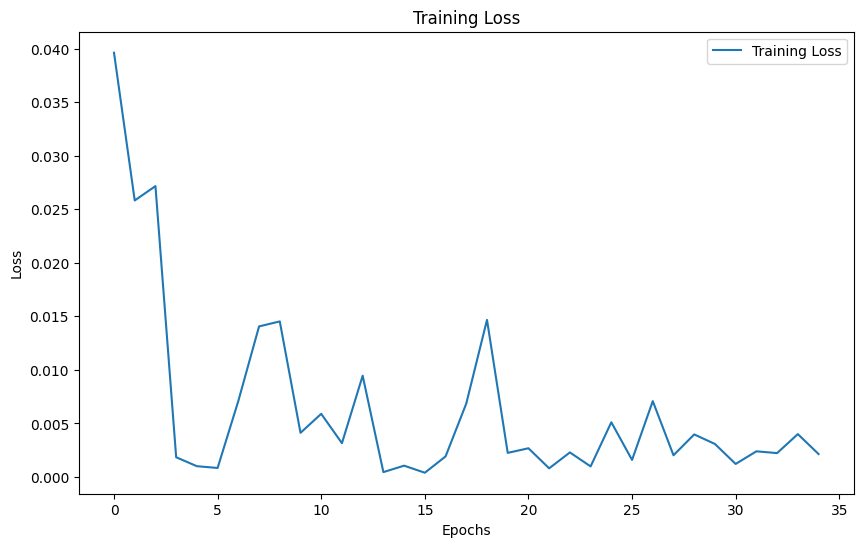

In [11]:
#Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(value_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [19]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())
print(np.array(predictions).shape)
print(y_test[:,0].shape)
print(scaler.inverse_transform(np.array(predictions)).shape)

predictions = scaler.inverse_transform(np.array(predictions))
y_test = scaler.inverse_transform(y_test)
#rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions)[:,0].reshape(-1, 1)) - scaler.inverse_transform(y_test[:,0].reshape(-1, 1)))**2))
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test[:,0], np.array(predictions)[:,0]))
print(f"Score (RMSE): {rmse:.4f}")

rmse = np.sqrt(mean_squared_error(y_test[:,1], np.array(predictions)[:,1]))
print(f"Score (RMSE): {rmse:.4f}")

(495, 2)
(495,)
(495, 2)
Score (RMSE): 30513.2962
Score (RMSE): 54452.0341


: 

In [15]:
import matplotlib.pyplot as plt
def plot_predictions_vs_actual_simple (predictions,actual, title='Predictions vs Actual'):
    """ 
    Plot the actual vs predicted results for data related to a given function of u

    Args:
        predictions (tensor): predicted values (y)
        actual (tensor): actual values including x (inputs) and y (expected output)
        title (str, optional): Title of plot. Defaults to 'Predictions vs Actual'.
    """
    plt.figure(figsize=(6, 4))

    val=""

           
    for i in range(actual.shape[1]):
        if i ==1:
            val = 'u'
        else:
            val = 'x'
        
        # print('actual: ',actual[:,i])
        # print('predicted: ',predictions[:,i])
        plt.plot(actual[:,i], '-o',label=f'Actual Values {val}')
        plt.plot(predictions[:,i],'x', label=f'Predicted Values {val}')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

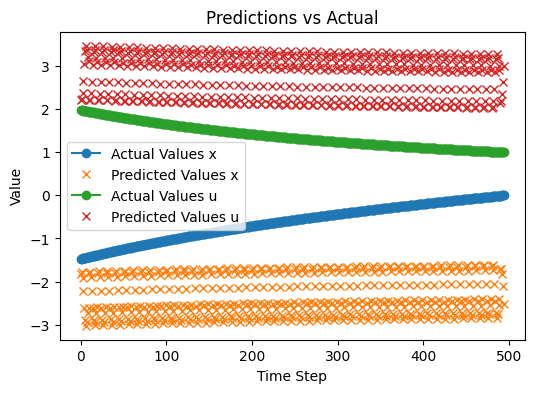

In [16]:
plot_predictions_vs_actual_simple(np.array(predictions), y_test)

In [ ]:
# # Positional Encoding for Transformer
# class DecoderPositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=20):
#         super(DecoderPositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)


# # Model definition using Transformer
# class DecoderTransformerModel(nn.Module):
#     global num_timesteps
#     # attention head = 4
#     # encode layers = 2
#     # input seq of size 1 (1 token)
#     # embedding dim = 64
#     # dropout = 0.2 --> every training step each neuron has 20% chance of not contributing (to the forward pass and  being updated during backward pass)
#     def __init__(self, input_dim=num_timesteps, d_model=2, nhead=2, num_layers=1, dropout=0.2):
#         super(DecoderTransformerModel, self).__init__()

#         # info
#         self.model_type = "Transformer"
#         self.d_model = d_model

#         # define layers
#         #self.embedding = nn.Linear(input_dim, d_model) #(input eg [128,20] with nn.Linear(20,50) --> output [128,50])
#         self.pos_encoder = DecoderPositionalEncoding(d_model, dropout)
#         decoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=10, dropout=dropout, activation="relu", layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=device)
#         self.transformer_decoder = nn.TransformerEncoder(decoder_layers, num_layers,mask_check=True)
#         self.linear = nn.Linear(d_model, 2)

#     def forward(self, x, decoder_mask=None):
#         #x = self.embedding(x)
#         x = self.pos_encoder(x)
#         x = self.transformer_decoder(x, decoder_mask)
#         x = self.linear(x[:, -1, :]) #the output from the last token of the sequence is passed through a linear layer to produce the final model output.
#         return x

#     def get_decoder_mask(self, size) -> torch.tensor:
#         # Generates a squeare matrix where the each row allows one element more to be seen
#         mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
#         mask = mask.float()
#         mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
#         mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
#         #print('maask', mask)
#         # EX for size=5:
#         # [[0., -inf, -inf, -inf, -inf],
#         #  [0.,   0., -inf, -inf, -inf],
#         #  [0.,   0.,   0., -inf, -inf],
#         #  [0.,   0.,   0.,   0., -inf],
#         #  [0.,   0.,   0.,   0.,   0.]]

#         return mask

# decoder_model = DecoderTransformerModel().to(device)

In [ ]:
# Train the decoder model
'''
On CPU train time = 9 min 45s
On google collab GPU the model is trained in a matter of seconds
'''
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(decoder_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')
i = 0
for epoch in range(epochs):
    decoder_model.train()
    for batch in train_dataloader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Get mask to mask out the next words
        sequence_length = x_batch.size(0)
        decoder_mask = decoder_model.get_decoder_mask(sequence_length).to(device)

        optimizer.zero_grad()
        outputs = decoder_model(x_batch,decoder_mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    decoder_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_dataloader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = decoder_model(x_batch,decoder_mask)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Stopping: Loss increasing")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

NameError: name 'decoder_model' is not defined

In [ ]:
# Evaluation of decoder model
from torch.nn.functional import mse_loss

decoder_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        output = decoder_model(x_batch)
        print(output)
        # Store predictions and targets
        all_predictions.append(output)
        all_targets.append(y_batch)

print(all_predictions)
print(all_targets)
# Concatenate all batches
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate MSE and then take the square root to get RMSE
mse = mse_loss(all_predictions, all_targets)
rmse = np.sqrt(mse.item())

print(f'Test RMSE: {rmse}')
print(all_predictions.shape)
print(all_targets.shape)

#RMSE: The root mean square error (RMSE) measures the average difference between a statistical model’s predicted values and the actual values. 
# Mathematically, it is the standard deviation of the residuals. It is a non-standardized (0->inf) metric of a model's goodness of fit. 
# It uses the units of the dependent variable and gives a direct assessment of prediction precision. It is sensitive to outliers.
# https://statisticsbyjim.com/regression/root-mean-square-error-rmse/

#R-squared: A standardized (0->1) goodness of fit metric which is unitless. It is sensitive to outliers (see adjusted R-squared).
#R-squared is the percentage of the response variable variation that is explained by a linear model (how close the data are to the fitted regression line).
# R-squared = 1 - (SSR / SST)
# The sum squared regression (SSR) is the sum of the squared differences between the predicted values and the actual values.
# The total sum of squares (SST) represents the sum of the squares of the differences between each actual value and the overall mean of the data set.

# Check back design of experiments course

tensor([[-1.1064,  1.3639]])
tensor([[-1.1064,  1.3639]])
tensor([[-1.1064,  1.3639]])
[tensor([[-1.1064,  1.3639]]), tensor([[-1.1064,  1.3639]]), tensor([[-1.1064,  1.3639]])]
[tensor([[[0.7804, 0.3576],
         [0.7815, 0.3578],
         [0.7826, 0.3581],
         [0.7838, 0.3583],
         [0.7849, 0.3586],
         [0.7860, 0.3588],
         [0.7872, 0.3591],
         [0.7883, 0.3594],
         [0.7894, 0.3596],
         [0.7905, 0.3599],
         [0.7917, 0.3601],
         [0.7928, 0.3604],
         [0.7939, 0.3606],
         [0.7951, 0.3609],
         [0.7962, 0.3612],
         [0.7973, 0.3614],
         [0.7985, 0.3617],
         [0.7996, 0.3620],
         [0.8007, 0.3622],
         [0.8019, 0.3625],
         [0.8030, 0.3627],
         [0.8041, 0.3630],
         [0.8053, 0.3633],
         [0.8064, 0.3635],
         [0.8075, 0.3638],
         [0.8087, 0.3641],
         [0.8098, 0.3643],
         [0.8109, 0.3646],
         [0.8121, 0.3649],
         [0.8132, 0.3651],
         [0

C:\Users\sian_\AppData\Local\Temp\ipykernel_27948\1173641976.py:25: UserWarning: Using a target size (torch.Size([3, 399, 2])) that is different to the input size (torch.Size([3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = mse_loss(all_predictions, all_targets)


RuntimeError: The size of tensor a (3) must match the size of tensor b (399) at non-singleton dimension 1

ValueError: x and y can be no greater than 2D, but have shapes (3,) and (3, 399, 2)

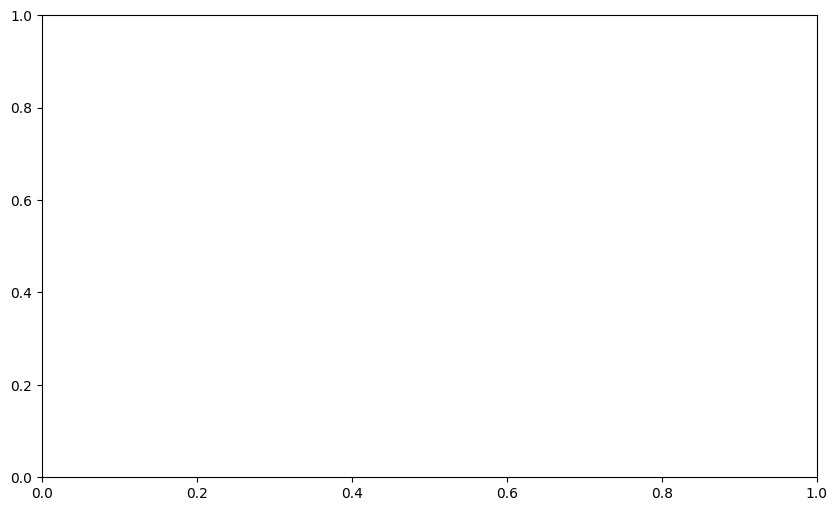

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions_vs_actual(predictions, actual, title='Predictions vs Actual'):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Assuming 'all_predictions' and 'all_targets' are your model's predictions and actual values respectively
plot_predictions_vs_actual(all_predictions.cpu().numpy(), all_targets.cpu().numpy(), title='Test Predictions vs Actual')

# Calculating and displaying RMSE and R²
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(all_targets.cpu().numpy(), all_predictions.cpu().numpy()))
r_squared = r2_score(all_targets.cpu().numpy(), all_predictions.cpu().numpy())

print(f'Test RMSE: {rmse}')
print(f'Test R²: {r_squared}')
